# Masked Language Modelling and Sequence Classification with Bert
### HW3 @ DL Course, Dr. Soleymani

*Full Name:* Amirhossein Alamdar

*SID:* 400105144

In this notebook, we leverage the "rotten_tomatoes" dataset from HuggingFace, containing movie reviews from Rotten Tomatoes. Our objectives are twofold:


1.   Perform Masked Language Modeling (MLM) on the training portion of provided dataset.
2.   Construct a classifier to discern between positive and negative reviews.

To achieve these goals, we employ a customized smaller version of BERT. This choice facilitates training and computation, ensuring efficiency and feasibility.

In [24]:
# Install necessary packages
# %%capture
# !pip install datasets
# !pip install transformers
!pip install evaluate
# !pip install accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from datasets import load_dataset
import matplotlib.pyplot as plt

In [3]:
# Set up basic configurations for training
batch_size = 32
learning_rate = 1e-5
num_epoch = 5
num_labels = 2
np.random.seed(42)
torch.manual_seed(42)

# Select device for training (GPU if available, otherwise CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the Rotten Tomatoes dataset
dataset = load_dataset('rotten_tomatoes')
dataset

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

In all subsequent sections, we utilize the pre-trained BERT tokenizer. Thus, we begin by importing and initializing it here.

In [5]:
# Import BertTokenizer from the transformers library
from transformers import BertTokenizer

# Load the pre-trained BertTokenizer model 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

We will utilize this configuration for the BERT model in subsequent sections.

In [6]:
# Import BertConfig from the transformers library
from transformers import BertConfig

# Define configuration parameters for the BERT model
config = BertConfig(
    hidden_size = 384,
    vocab_size= tokenizer.vocab_size,
    num_hidden_layers = 6,
    num_attention_heads = 6,
    intermediate_size = 1024,
    max_position_embeddings = 256
)

# 1 Masked Language Modeling

Masked Language Modeling (MLM) is a fundamental task in natural language processing (NLP) where a `head` is placed on top of a `BERT` (Bidirectional Encoder Representations from Transformers) model to `perform predictions`.
In MLM, certain words or tokens in a sentence are randomly masked or replaced with a special token, and the model is trained to predict the original words based on the context of the surrounding tokens. The objective of MLM is to encourage the model to learn contextual relationships between words and understand the overall structure and semantics of the language. During training, the model receives input sequences with masked tokens and is trained to generate the correct tokens for the masked positions. MLM serves as a crucial pre-training step in learning rich contextual representations of words, which can be transferred to downstream tasks such as text classification, named entity recognition, and question answering.
![](https://editor.analyticsvidhya.com/uploads/22971fig-3.png)
---

## 1.1 Dateset preparation for MLM

In [8]:
# Define a function to preprocess text data for masked language modeling (MLM)
def mlm_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], max_length=128, padding="max_length", truncation=True, return_tensors='pt')
    return {
        **input_info,
        'labels': input_info['input_ids']
        }

# Apply the mlm_map_function to the dataset for masked language modeling (MLM)
mlm_dataset = dataset.map(mlm_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names)

Map (num_proc=2):   0%|          | 0/8530 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

In [9]:
# Import DataCollatorForLanguageModeling from transformers
from transformers import DataCollatorForLanguageModeling

# Create a data collator for MLM training
collate_fn = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.15)

# Create a DataLoader for MLM training
train_dataloader = torch.utils.data.DataLoader(
    mlm_dataset['train'],
    collate_fn=collate_fn,
    batch_size=batch_size
    )


2024-05-01 07:33:21.063267: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 07:33:21.063404: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 07:33:21.201786: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 1.2 BertModel + MLMHead + Custom trainer

In [30]:
class MLMHead(nn.Module):
    """
    Multi-Layer Perceptron (MLP) head for Masked Language Modeling (MLM) task.

    Parameters:
        bert_model (torch.nn.Module): BERT model.
        hidden_size (int): Size of the hidden layers in the MLP head. Default is 384.
        vocab_size (int): Size of the vocabulary. Default is 30522.
    """

    def __init__(self, bert_model, hidden_size=384, vocab_size=30522):
        super(MLMHead, self).__init__()
        ######################  TODO  ########################
        ######################  TODO  ########################
        # construct layers and structure of the network

        self.embedder = bert_model
        self.dense = nn.Linear(bert_model.config.hidden_size, hidden_size)
        self.activation = nn.GELU()
        self.layernorm = nn.LayerNorm(hidden_size)
        self.decoder = nn.Linear(hidden_size, vocab_size)

        ######################  TODO  ########################
        ######################  TODO  ########################

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the MLMHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the MLM head.
        """
        ######################  TODO  ########################
        ######################  TODO  ########################
        # implement the forward pass of your model.
        # the sentence, the get the embeddings from your language
        # model, then use the `last_hidden_states` for your MLMHead
        # layer.

        outputs = self.embedder(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state

        x = self.dense(sequence_output)
        x = self.activation(x)
        x = self.layernorm(x)
        output = self.decoder(x)

        ######################  TODO  ########################
        ######################  TODO  ########################

        return output


In [31]:
from transformers import BertModel
bert = BertModel(config)
######################  TODO  ########################
######################  TODO  ########################
mlm_model = MLMHead(bert)
optimizer = torch.optim.Adam(mlm_model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

######################  TODO  ########################
######################  TODO  ########################

In [32]:
######################  TODO  ########################
######################  TODO  ########################
# implement your training loop and train your model.

mlm_model.to(device)
losses = []
for epoch in range(num_epoch):
    train_loss = 0.0
    for data in train_dataloader:
        inputs = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        targets = data['labels'].to(device)

        outputs = mlm_model(inputs, mask)
        loss = criterion(outputs.permute(0, 2, 1), targets)
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    train_loss /= len(train_dataloader)

    print(f'Epoch [{epoch+1}/{num_epoch}], Train Loss: {train_loss:.4f}')
######################  TODO  ########################
######################  TODO  ########################

Epoch [1/5], Train Loss: 9.3363
Epoch [2/5], Train Loss: 8.2342
Epoch [3/5], Train Loss: 7.6398
Epoch [4/5], Train Loss: 7.3158
Epoch [5/5], Train Loss: 7.1193


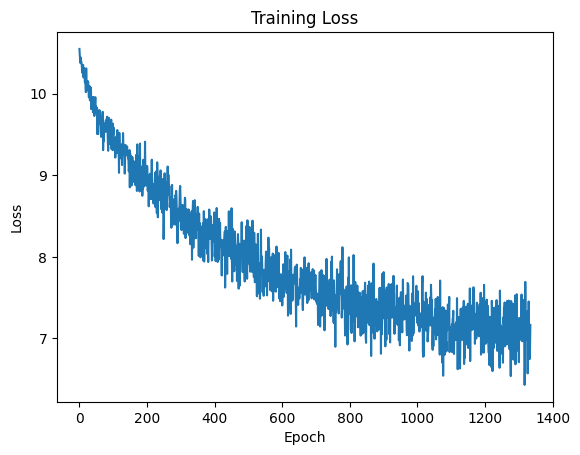

In [33]:
# Plot the losse for every batch in training process
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 1.3 BertForMaskedLM + huggingface trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForMaskedLM` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.

In [35]:
######################  TODO  ########################
######################  TODO  ########################
from transformers import BertForMaskedLM, Trainer, TrainingArguments

hugg_model = BertForMaskedLM(config).to(device)
training_args = TrainingArguments(
    output_dir="/kaggle/working/",                        
    evaluation_strategy="epoch",                   
    learning_rate=learning_rate,                    
    per_device_train_batch_size=batch_size,         
    num_train_epochs=num_epoch,                     
    weight_decay=1e-2,                            
    logging_dir='/kaggle/working/',                           
    logging_steps=100,                      
    save_strategy="epoch",                       
    load_best_model_at_end=True,                  
    metric_for_best_model="loss"                   
)

trainer = Trainer(
    model=hugg_model,
    args=training_args,
    train_dataset=mlm_dataset['train'],           
    eval_dataset=mlm_dataset['validation'],        
    data_collator=collate_fn,                     
    tokenizer=tokenizer                        
)

trainer.train()
######################  TODO  ########################
######################  TODO  ########################

/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,9.349900,8.864634
2,8.456600,8.270534
3,8.001900,7.944120
4,7.823200,7.771038
5,7.764400,7.722552


There were missing keys in the checkpoint model loaded: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias'].


TrainOutput(global_step=1335, training_loss=8.353555332140976, metrics={'train_runtime': 467.801, 'train_samples_per_second': 91.171, 'train_steps_per_second': 2.854, 'total_flos': 277250297932800.0, 'train_loss': 8.353555332140976, 'epoch': 5.0})

# 2 Sequence Classification

When you look at how `BERT encodes` text, you'll see that it creates a `vector` for each word in the input sentence. But for basic classification tasks, we don't need all those individual word vectors.

Instead, we can just use the `first token's vector` because it captures the overall meaning of the sentence. BERT conveniently provides this vector for us in a special variable called `pooler_output`. So, in our classifier model, we'll use this pooler_output as the input for our classification head.
![BERT pooler output](https://miro.medium.com/max/1100/1*Or3YV9sGX7W8QGF83es3gg.webp)

## 2.1 Dataset preparation for sequence classification

In [109]:
# Define a function to preprocess text data for classification
def cls_map_function(rows):
    # Tokenize the text with specified tokenizer parameters
    input_info = tokenizer(rows['text'], truncation=True, max_length=128, padding=True)
    return {
        **input_info,
        'labels': rows['label']
        }

features = Features({"input_ids": Sequence(Value("int64")), 
                                        "token_type_ids": Sequence(Value("int64")), 
                                        "attention_mask": Sequence(Value("float32")), 
                                        "labels": Value("float32")})

# Apply the cls_map_function to the dataset for classification
cls_dataset = dataset.map(cls_map_function, batched=True, num_proc=2, remove_columns=dataset['train'].column_names, features = features)

Map (num_proc=2):   0%|          | 0/8530 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1066 [00:00<?, ? examples/s]

In [111]:
cls_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1066
    })
})

In [19]:
# Import DataCollatorWithPadding from transformers
from transformers import DataCollatorWithPadding

# Create a data collator with padding
col_fn = DataCollatorWithPadding(
    tokenizer, return_tensors='pt', padding='longest',
)

# Create a DataLoader for training data
train_loader = torch.utils.data.DataLoader(
    cls_dataset['train'],
    batch_size=batch_size,
    collate_fn=col_fn,
    shuffle=True
)

# Create a DataLoader for test data
test_loader = torch.utils.data.DataLoader(
    cls_dataset['test'],
    batch_size=batch_size,
    collate_fn=col_fn,
)

## 2.2 BertModel + ClassifierHead + Custom trainer

In [29]:
class ClassifierHead(nn.Module):
    """
    Classifier head for classification tasks.

    Parameters:
        embedding_model (torch.nn.Module): bert model.
        num_classes (int): Number of classes for classification. Default is 2.
    """

    def __init__(self, embedding_model, num_classes=2):
        super().__init__()
        ######################  TODO  ########################
        ######################  TODO  ########################
        # construct layers and structure of the network
        self.embedder = embedding_model
        if num_classes == 2:
            num_classes = 1
        self.classifier = nn.Linear(embedding_model.config.hidden_size, num_classes)
        self.sigmoid = nn.Sigmoid()
        ######################  TODO  ########################
        ######################  TODO  ########################

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the ClassifierHead module.

        Parameters:
            input_ids (torch.Tensor): Tensor containing input token IDs.
            attention_mask (torch.Tensor): Tensor containing attention mask.

        Returns:
            torch.Tensor: Output tensor of the classifier head.
        """
        ######################  TODO  ########################
        ######################  TODO  ########################
        # implement the forward pass of your model.
        # the sentence, the get the embeddings from your language
        # model, then use the `pooler_output` for your classifier
        # layer.
        
        output = self.embedder(input_ids, attention_mask).pooler_output
        output = self.sigmoid(self.classifier(output))

        ######################  TODO  ########################
        ######################  TODO  ########################
        return output

In [54]:
# Define the function to compute metrics
import evaluate
accuracy = evaluate.load("accuracy")
from transformers import BertModel

# Define the BERT model
bert = BertModel(config=config)

# Define the classifier head
cls_model = ClassifierHead(bert, 2)
optimizer = torch.optim.Adam(cls_model.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
######################  TODO  ########################
######################  TODO  ########################

In [55]:
######################  TODO  ########################
######################  TODO  ########################
# implement your training loop and train your model.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
cls_model.to(device)
losses = []
num_epoch = 8
for epoch in range(num_epoch):
    train_loss = 0.0
    for data in train_loader:
#         print(data.keys())
        inputs = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        targets = data['labels'].to(device)

        outputs = cls_model(inputs, mask)
#         print(outputs.shape, targets.shape)
        loss = criterion(outputs.view(-1), targets.float())
        train_loss += loss.item()
#         print(outputs.shape, targets.shape)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
    train_loss /= len(train_loader)
    
    print(f'Epoch [{epoch+1}/{num_epoch}], Train Loss: {train_loss:.4f}')
######################  TODO  ########################
######################  TODO  ########################

Epoch [1/8], Train Loss: 0.6950
Epoch [2/8], Train Loss: 0.6843
Epoch [3/8], Train Loss: 0.6187
Epoch [4/8], Train Loss: 0.4786
Epoch [5/8], Train Loss: 0.3979
Epoch [6/8], Train Loss: 0.3391
Epoch [7/8], Train Loss: 0.2932
Epoch [8/8], Train Loss: 0.2617


In [56]:
cls_model.eval()

total_correct = 0
total_samples = 0

# Disable gradient computation
with torch.no_grad():
    for data in test_loader:
        inputs = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        targets = data['labels'].to(device)
        
        outputs = cls_model(inputs, mask).view(-1)
        predicted = (outputs > 0.5).int()

        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        
accuracy = total_correct / total_samples

print("Accuracy:", accuracy)

Accuracy: 0.7711069418386491


## 2.3 BertForSequenceClassification + Hugginface Trainer

[HuggingFace library](http://huggingface.co/) has built a nice API for NLP tasks around the transformers. To get familiar with this comrehensive library, In this section you are asked to use the huggingface `Trainer`, `Dataset`, and `BertForSequenceClassification` to do what we did above again.

Feel free to refer to the library documentation to learn about these modules.

You should utilize the prepared dataset and configuration from earlier.(You can include any additional required attributes to configuration.)

In [112]:
######################  TODO  ########################
######################  TODO  ########################
num_epoch = 5
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)
model.to(device)
training_args=TrainingArguments(
    output_dir='/kaggle/working/',
    evaluation_strategy="epoch",
    num_train_epochs=num_epoch,
    learning_rate=learning_rate,
    weight_decay=0.01,
)
trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=cls_dataset['train'],
    eval_dataset=cls_dataset['validation'],
    tokenizer=tokenizer
)
trainer.train()
trainer.evaluate()
######################  TODO  ########################
######################  TODO  ########################

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.117000,0.109370
2,0.071800,0.119240
3,0.041900,0.114098
4,0.028000,0.115595
5,0.021100,0.118312


{'eval_loss': 0.11831175535917282,
 'eval_runtime': 2.7889,
 'eval_samples_per_second': 382.23,
 'eval_steps_per_second': 48.048,
 'epoch': 5.0}

In [130]:
import torch.nn.functional as F
model.eval()

total_correct = 0
total_samples = 0

# Disable gradient computation
with torch.no_grad():
    for data in test_loader:
        inputs = data['input_ids'].to(device)
        mask = data['attention_mask'].to(device)
        targets = data['labels'].to(device)
        outputs = model(inputs, mask).logits.view(-1)
        
        predicted = (outputs > 0.5).int()

        total_correct += (predicted == targets).sum().item()
        total_samples += targets.size(0)
        
accuracy = total_correct / total_samples

print("Accuracy:", accuracy)

Accuracy: 0.8611632270168855
